# Building a Corona Index to improve the error analysis of Demand Forecasting
This process is split into six steps
- Understand the data components
- Check the changepoint date(s)
- Measure the casual impact of corona
- Forcast the demand
- Adjust the forecast by adding the casual effect
- Evaluate the errors of the different types of adjustments



### Understanding the data components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.models.prophet import ProphetModel, ProphetParams
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


plt.rcParams["figure.figsize"] = (14,5)
sns.set_style('darkgrid')

In [2]:
#the data has a monthly frequency sales 
data = pd.read_csv('data/Retail Sales.csv')
data.head()

,DATE,Sales
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


In [3]:
# converting the datframe to a Timeseries to use the kat library
data.columns = ["time", "value"]
ts = TimeSeriesData(data)


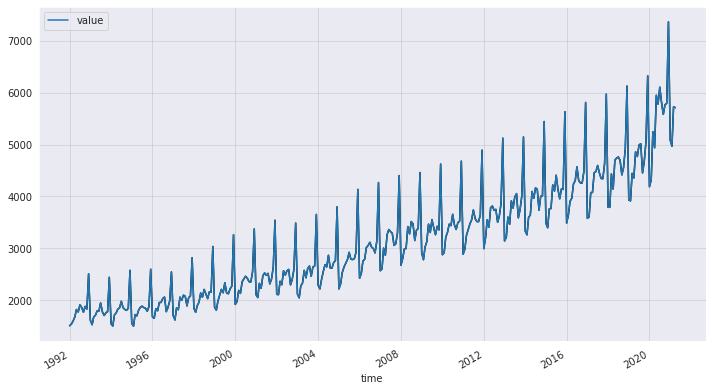

In [4]:
# below, we can see that there was a surge in trend sales around 2020
ts.plot(cols=['value'])

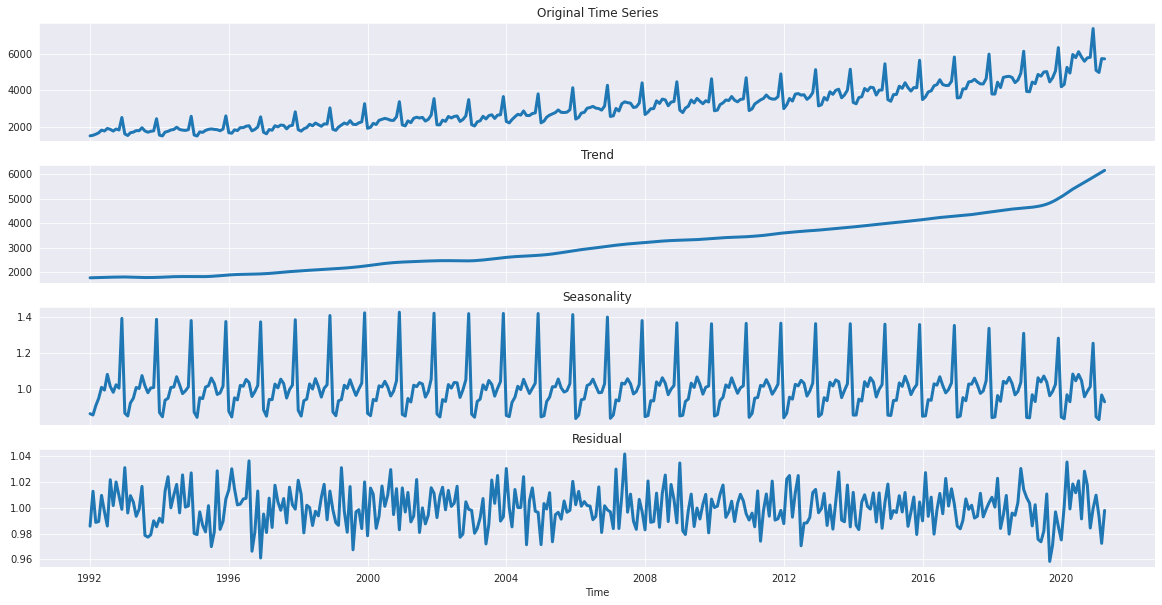

In [5]:
# decompose and visiualize the pattern
decomposer = TimeSeriesDecomposition(ts, decomposition="multiplicative")
results = decomposer.decomposer()
fig = decomposer.plot()

Key things to noted from the above viz
- There is a trend and a monthly seasonality which spikes around december time (celebration period ) and drops in january
- There is an obvious change in trendline pattern that makes the line steeper in 2020
- The trend and seasonality pattern indicates non-stationarity and auto-correlation as we can sense that the previous sales numbers(lags) would influence the recent sales numbers. Also we can also observe that the mean/variance is never constant(hence, it is not stationary)
- Finally, the best time of model for this forecast is the multiplicative model because the magnitude of the seasonality pattern changes as data increases. More info [here](https://sigmundojr.medium.com/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7)

### Detect the sudden Change points

TimeSeriesChangePoint(start_time: 2020-05-01T00:00:00.000000000, end_time: 2020-05-01T00:00:00.000000000, confidence: 0.7075252873104964)


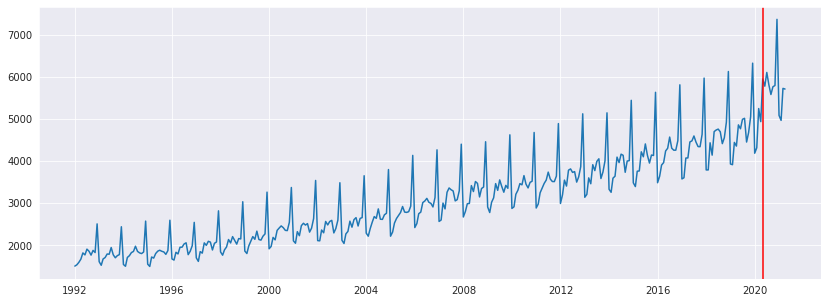

None


In [6]:
# check what time /month had a sudden change in sales pattern
bocpd_detector = BOCPDetector(ts)

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.1
)
for changepoint in changepoints:
    print(changepoint[0])
    
# Plot
print(bocpd_detector.plot(changepoints))


### Split the data into Training and Test set

In [7]:
 
df = ts.to_dataframe()
df['time'] = df['time'].dt.to_period('M').dt.to_timestamp('M')

# split the data
training_set = df.iloc[:-8,:]
test_set = df.iloc[-8:,:]

#prep the data to input to the casual impavt library
training_set_inference = training_set.set_index('time')

training_set_inference.head()

,value
time,
1992-01-31,1509
1992-02-29,1541
1992-03-31,1597
1992-04-30,1675
1992-05-31,1822


### Measure the Casual Impact

In [8]:
# Define training data - period prior to the event
pre_period = ['1992-01-31', '2020-04-30'] 
# Define post-event period - i.e. time AFTER the event occurred.
post_period = ['2020-05-31', '2020-08-31'] 
# Instantiate CI model.
ci = CausalImpact(training_set_inference, pre_period, post_period, nseasons=[{'period': 12}])

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



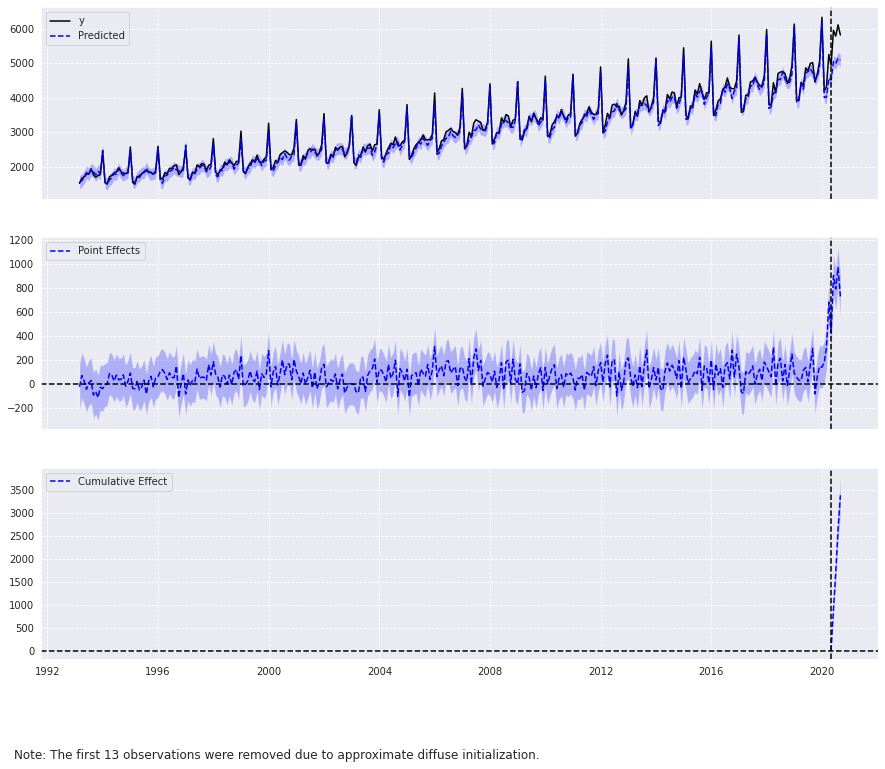

In [9]:
# Vizualize the impact
ci.plot()

In [10]:
# get the effect numbers
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5912.25            23649.0
Prediction (s.d.)         5064.98 (52.52)    20259.94 (210.07)
95% CI                    [4961.7, 5167.56]  [19846.79, 20670.25]

Absolute effect (s.d.)    847.27 (52.52)     3389.06 (210.07)
95% CI                    [744.69, 950.55]   [2978.75, 3802.21]

Relative effect (s.d.)    16.73% (1.04%)     16.73% (1.04%)
95% CI                    [14.7%, 18.77%]    [14.7%, 18.77%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [11]:
# see the report
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5912.25. By contrast, in the absence of an
intervention, we would have expected an average response of 5064.98.
The 95% interval of this counterfactual prediction is [4961.7, 5167.56].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 847.27 with a 95% interval of
[744.69, 950.55]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 23649.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 20259.94. The 95% interval of this prediction is [19846.79, 20670.25].


The above results are given in terms of absolute numbers. In relative
terms, th

In [12]:
#the regression evaluation, coefficients etc
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                 value   No. Observations:                  340
Model:                                   local level   Log Likelihood                 211.790
                   + stochastic freq_seasonal(12(6))   AIC                           -417.580
Date:                               Tue, 07 Sep 2021   BIC                           -406.210
Time:                                       10:49:20   HQIC                          -413.043
Sample:                                   01-31-1992                                         
                                        - 04-30-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0029      0.000      7.562      0.000       0.002       0.004
sigma2.level                   0.0001   1.38e-05     10.456      0.000       0.000       0.000
sigma2.freq_seasonal_12(6)  2.963e-05   5.14e-06      5.767      0.000    1.96e-05    3.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.12   Jarque-Bera (JB):               387.29
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



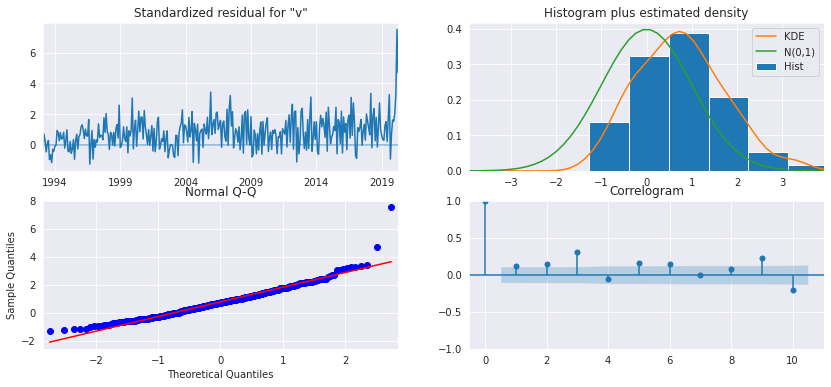

In [13]:
# the distribution of the residuals from the casual impact prediction
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

##### Key things to observe
- The relative effect of the pandemic on sales demand is positive and about 16% with boundary between 14% and 18%
- the model seems to be 100% sure that there is a causal impact
- The AIC is negative which is a good sign for the model evaluation. ( The small the AIC, the better) 
- The distribution of the residual is looks normal . However, there is still some autocorrelation

### Bulding a forecasting model using the training set

In [14]:
kat_series = TimeSeriesData(training_set)

In [15]:
#using prophet in kat library
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(kat_series, params)

# Fit mode
m.fit()

# Forecast
forecast = m.predict(steps=8, freq='M')
# print(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Initial log joint probability = -4.71999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1176.3    0.00188434       166.243      0.1573      0.1573      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1181.55   0.000101941        168.43   7.197e-07       0.001      250  LS failed, Hessian reset 
     199        1183.2     0.0039196       220.267           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       1183.34   0.000871969       368.834   6.463e-06       0.001      330  LS failed, Hessian reset 
     262       1184.22   6.67804e-05       115.102   5.223e-07       0.001      4

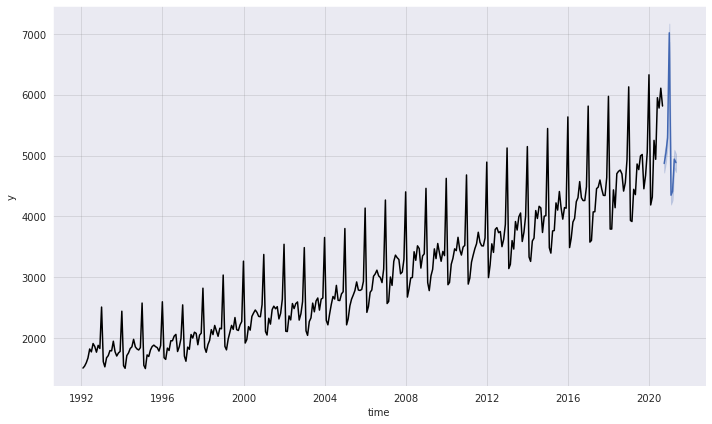

In [16]:
# visualize the forecast
m.plot()

In [17]:
# the forecast in a dataframe as well as the  test set value
forecast_dataframe = pd.DataFrame(forecast).round(0)
forecast_dataframe['actual_sales'] = list(test_set['value'].values)
forecast_dataframe['if_meet_boundaries'] =  forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_lower'], forecast_dataframe['fcst_upper'])
forecast_dataframe

,time,fcst,fcst_lower,fcst_upper,actual_sales,if_meet_boundaries
0,2020-09-30,4869.0,4721.0,5020.0,5582,False
1,2020-10-31,5038.0,4886.0,5177.0,5766,False
2,2020-11-30,5289.0,5147.0,5436.0,5796,False
3,2020-12-31,7016.0,6867.0,7166.0,7366,False
4,2021-01-31,4348.0,4196.0,4496.0,5087,False
5,2021-02-28,4413.0,4267.0,4565.0,4968,False
6,2021-03-31,4941.0,4802.0,5094.0,5727,False
7,2021-04-30,4884.0,4728.0,5027.0,5712,False


From the above dataframe, we see that the forecasts are greatly underestimating the demand and didn't pick up the suddent change in pattern which is expected

### Adjust the forecasted demand by adding the relative effect of the pandamic  

In [18]:
#extracting the relative efferct of the casual inference
relative_effect_sales = (ci.summary_data.loc[['rel_effect_lower','rel_effect','rel_effect_upper'],['average']].values).T + 1
effect_names = ['rel_effect_lower','rel_effect','rel_effect_upper']

In [19]:
#build the different forecasts with the different relative effect bound to get adjusted forecast demands
dataframe_columns=['fcst', 'fcst_lower', 'fcst_upper']
def get_adjusted_forecasts(forecast_dataframe,dataframe_columns, relative_effect_sales):
    """
    For each forecast column, adjust the demand by each relative effect boundaries and store the results in a dictionary
    """
    dic_store = {}
    for column in dataframe_columns:
        forecast_value = forecast_dataframe[column].values.reshape(-1,1)
        adjusted_results = forecast_value * relative_effect_sales
        dic_store[column] = adjusted_results.T
        
    return dic_store


def add_adjusted_forecast_to_dataframe(forecast_dataframe,dataframe_columns, relative_effect_sales):
    """
    Get the adjusted demands and create new columns for them in the dataframe
    """
    results = get_adjusted_forecasts(forecast_dataframe,dataframe_columns, relative_effect_sales)
    print('done')
    for k,v in results.items():
        forecast_dataframe[k+'_'+effect_names[0]],forecast_dataframe[k+'_'+effect_names[1]], forecast_dataframe[k+'_'+effect_names[2]]  = v[0],v[1],v[2]
    print('done')



In [20]:
# call the function
add_adjusted_forecast_to_dataframe(forecast_dataframe,dataframe_columns, relative_effect_sales)

done
done


In [21]:
#check the columns
forecast_dataframe.columns

Index(['time', 'fcst', 'fcst_lower', 'fcst_upper', 'actual_sales',
       'if_meet_boundaries', 'fcst_rel_effect_lower', 'fcst_rel_effect',
       'fcst_rel_effect_upper', 'fcst_lower_rel_effect_lower',
       'fcst_lower_rel_effect', 'fcst_lower_rel_effect_upper',
       'fcst_upper_rel_effect_lower', 'fcst_upper_rel_effect',
       'fcst_upper_rel_effect_upper'],
      dtype='object')

In [22]:
# check if the new columns are within the boundaries of the actual sales demand
forecast_dataframe = forecast_dataframe.round(0)
forecast_dataframe['if_adjustments_forecast_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_rel_effect_lower'], forecast_dataframe['fcst_rel_effect_upper'])
forecast_dataframe['if_adjustments_forecast_lower_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_lower_rel_effect_lower'], forecast_dataframe['fcst_lower_rel_effect_upper'])
forecast_dataframe['if_adjustments_forecast_upper_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_upper_rel_effect_lower'], forecast_dataframe['fcst_upper_rel_effect_upper'])

forecast_dataframe

,time,fcst,fcst_lower,fcst_upper,actual_sales,if_meet_boundaries,fcst_rel_effect_lower,fcst_rel_effect,fcst_rel_effect_upper,fcst_lower_rel_effect_lower,fcst_lower_rel_effect,fcst_lower_rel_effect_upper,fcst_upper_rel_effect_lower,fcst_upper_rel_effect,fcst_upper_rel_effect_upper,if_adjustments_forecast_meets_boundaries,if_adjustments_forecast_lower_meets_boundaries,if_adjustments_forecast_upper_meets_boundaries
0,2020-09-30,4869.0,4721.0,5020.0,5582,False,5585.0,5683.0,5783.0,5415.0,5511.0,5607.0,5758.0,5860.0,5962.0,False,True,False
1,2020-10-31,5038.0,4886.0,5177.0,5766,False,5779.0,5881.0,5983.0,5604.0,5703.0,5803.0,5938.0,6043.0,6149.0,False,True,False
2,2020-11-30,5289.0,5147.0,5436.0,5796,False,6067.0,6174.0,6282.0,5904.0,6008.0,6113.0,6235.0,6345.0,6456.0,False,False,False
3,2020-12-31,7016.0,6867.0,7166.0,7366,False,8048.0,8190.0,8333.0,7877.0,8016.0,8156.0,8220.0,8365.0,8511.0,False,False,False
4,2021-01-31,4348.0,4196.0,4496.0,5087,False,4987.0,5075.0,5164.0,4813.0,4898.0,4983.0,5157.0,5248.0,5340.0,True,False,False
5,2021-02-28,4413.0,4267.0,4565.0,4968,False,5062.0,5151.0,5241.0,4894.0,4981.0,5068.0,5236.0,5329.0,5422.0,False,True,False
6,2021-03-31,4941.0,4802.0,5094.0,5727,False,5667.0,5768.0,5868.0,5508.0,5605.0,5703.0,5843.0,5946.0,6050.0,True,False,False
7,2021-04-30,4884.0,4728.0,5027.0,5712,False,5602.0,5701.0,5801.0,5423.0,5519.0,5615.0,5766.0,5868.0,5970.0,True,False,False


### Evaluate and Compare the forecasted demand errors

In [25]:
columns_to_use = list(forecast_dataframe.select_dtypes(include=np.number).drop('actual_sales',axis=1).columns)

def evaluate_forecasts(columns_to_use):
    """
    Get the evaluation metrics( MAE, RMSE, MAPE)  for each of the columns apart from the actual sales columns and store in a dictionary
    """
    dic_to_store = {}
    for column in columns_to_use:
        mae = mean_absolute_error(forecast_dataframe['actual_sales'], forecast_dataframe[column])
        rmse = mean_squared_error(forecast_dataframe['actual_sales'], forecast_dataframe[column])
        mape = mean_absolute_percentage_error(forecast_dataframe['actual_sales'], forecast_dataframe[column])
        dic_to_store[column] = [mae,rmse, mape]
    return dic_to_store
    

In [26]:
# convert the dictionary to a dataframe
metric_values = evaluate_forecasts(columns_to_use)
metrics = pd.DataFrame(metric_values,index=['MAE', 'RMSE', 'MAPE'])
metrics = metrics.T

In [27]:
#highlight the lowest error for each of the error metric columns
metrics.style.applymap(lambda x: 'background-color : yellow' if x in list(metrics.min().values) else '')

,MAE,RMSE,MAPE
fcst,650.750000,446928.500000,0.116021
fcst_lower,798.750000,661885.750000,0.142078
fcst_upper,502.875000,276746.125000,0.089981
fcst_rel_effect_lower,166.625000,71659.875000,0.026306
fcst_rel_effect,208.125000,110090.125000,0.032925
fcst_rel_effect_upper,306.375000,170879.375000,0.049883
fcst_lower_rel_effect_lower,225.500000,67369.000000,0.037952
fcst_lower_rel_effect,189.125000,70559.625000,0.030416
fcst_lower_rel_effect_upper,186.750000,94673.000000,0.029323
fcst_upper_rel_effect_lower,268.625000,134461.625000,0.043807


### Recommendations
Using three error metrics: MAE, RMSE, MAPE, we can see that the forecast from the model along with the lower bound relative effect change gives the lowest errors using MAE and MAPE. However, the lower bound forecaast with the lower bound relative effect gives the lowest error.
Since RMSE gives penalizes highest errors differences, we would still to this as the metric to use. Lower bound forecast + the lower bound relative effect would be a good option to use and added to the pipeline. However, it is wise to know that 
- This pattern may change back as the world goes back to normalcy. A critical step would be to watch/monitor and check from changepoints from time to time
- The casual impact can be improved by training next data and adjusting the effects to the forecasts
- In general, it is also good to monitor the error metrics of this adjusted forecast overtime to decide when/if to drop it or not

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78737810-407f-49e2-ad32-0363e2fb2f04' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>